# SynapSee EDA

In [57]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import seaborn as sns



In [58]:
# Separate EEG data into chunks corresponding to each image
# Constants
EEG_SAMPLING_RATE = 125  # Hz
EEG_COLUMNS = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']

# Load EEG data
eeg_df = pd.read_csv('data\output_file_mateo-202311242102.csv')

# Load timestamps
timestamps_df = pd.read_csv('data/timestamps_mateo-202311242102.csv', header=None, names=['Image', 'Timestamp'])

# Add a column for end time of each image
timestamps_df['EndTimestamp'] = timestamps_df['Timestamp'].shift(-1)

# no stimuli index
no_stimuli_index = 0
# Iterate over the timestamps and separate EEG data
for index, row in timestamps_df.iterrows():
    start_time = row['Timestamp']
    end_time = row['EndTimestamp'] if not pd.isna(row['EndTimestamp']) else timestamps_df['Timestamp'].iloc[-1]

    # Calculate the corresponding indices in the EEG data
    start_index = int(start_time * EEG_SAMPLING_RATE)
    end_index = int(end_time * EEG_SAMPLING_RATE)

    # Get the chunk of EEG data
    eeg_chunk = eeg_df.iloc[start_index:end_index]

    # Determine the category or no stimuli
    if 'no_stimuli' in row['Image']:
        chunk_label = 'no_stimuli'
        image_index = no_stimuli_index
        no_stimuli_index += 1
    else:
        chunk_label = row['Image'].split('/')[2]  # Extract category from the path
        image_index = row['Image'].split('/')[3].split('.')[0]

    # Save to a new CSV
    eeg_chunk.to_csv(f'processed_data/eeg_data_{chunk_label}_{image_index}.csv', index=False)


In [59]:
# Plotting functions
def plot_in_grid(plots, grid_shape):
    """
    Plots a list of matplotlib plots in a grid layout.

    Parameters:
    - plots: A list of matplotlib plots.
    - grid_shape: A tuple (rows, columns) specifying the grid layout.
    """

    # Ensure that the number of plots does not exceed the grid capacity
    if len(plots) > grid_shape[0] * grid_shape[1]:
        raise ValueError("Number of plots exceeds the grid capacity")

    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Iterate over the plots and add them to the grid
    for i, plot in enumerate(plots):
        # Add a new subplot in the correct position
        ax = plt.subplot(grid_shape[0], grid_shape[1], i + 1)

        # Draw the plot in the subplot
        plot(ax)

    # Show the final layout
    plt.tight_layout()
    plt.show()

def plot_eeg_data_separate_plots(eeg_data):
    '''
    Plots all of the channels of the EEG data in separate plots
    Params:
        eeg_data: pandas DataFrame with the EEG data
    '''
    eeg_columns = eeg_data.columns
    fig, axs = plt.subplots(len(eeg_columns), 1, figsize=(10, 10))
    for i, column in enumerate(eeg_columns):
        axs[i].plot(eeg_data[column])
        axs[i].set_title(column)
        axs[i].set_xlabel('Time (ms)')
        axs[i].set_ylabel('Amplitude (uV)')
    plt.show()

def plot_eeg_data_same_plot(eeg_data, centered=False, plot=False):
    def plot_func(ax):
        eeg_columns = eeg_data.columns
        for column in eeg_columns:
            if centered:
                ax.plot(eeg_data[column] - np.mean(eeg_data[column]), label=column)
            else:
                ax.plot(eeg_data[column], label=column)

        title = 'Centered EEG data' if centered else 'EEG data'
        ax.set_title(title)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Amplitude (uV)')
        ax.legend(loc='upper right')

    if plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        plot_func(ax)
        plt.show()
    else:
        return plot_func



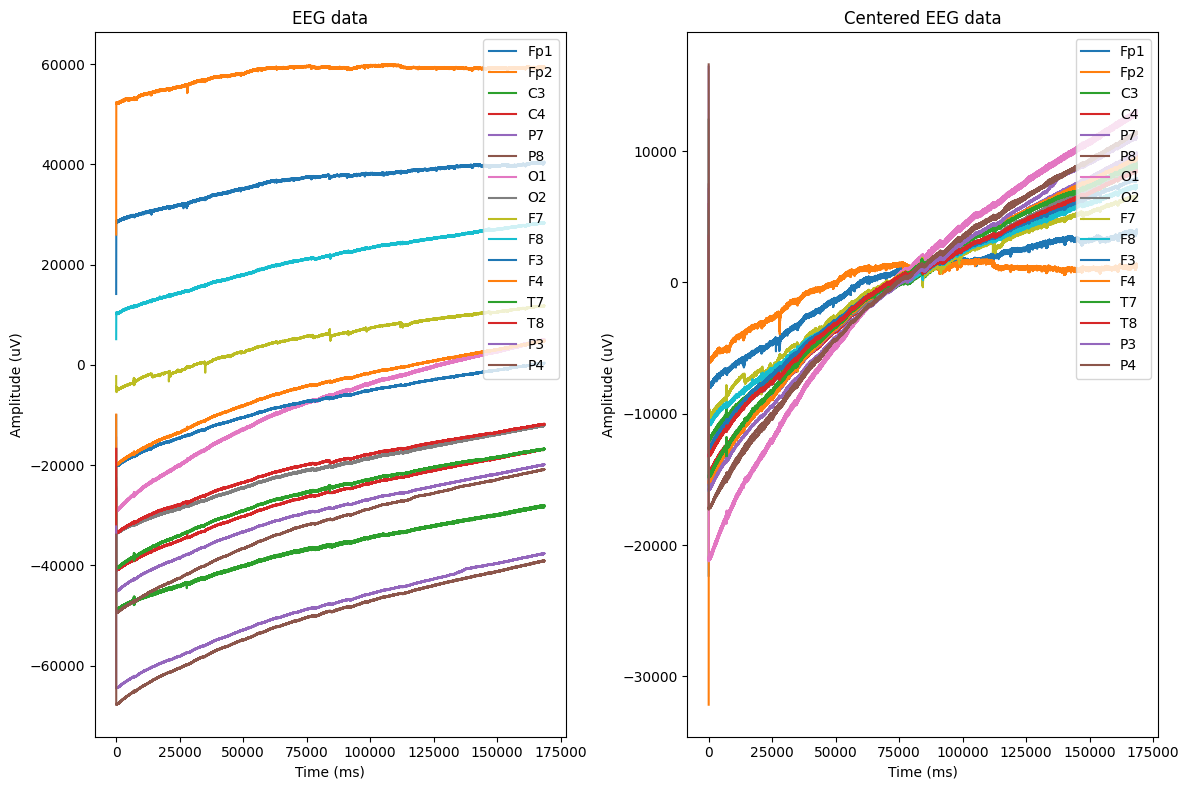

In [60]:
plot_in_grid([plot_eeg_data_same_plot(eeg_df),
            plot_eeg_data_same_plot(eeg_df, centered=True)], 
            (1, 2))

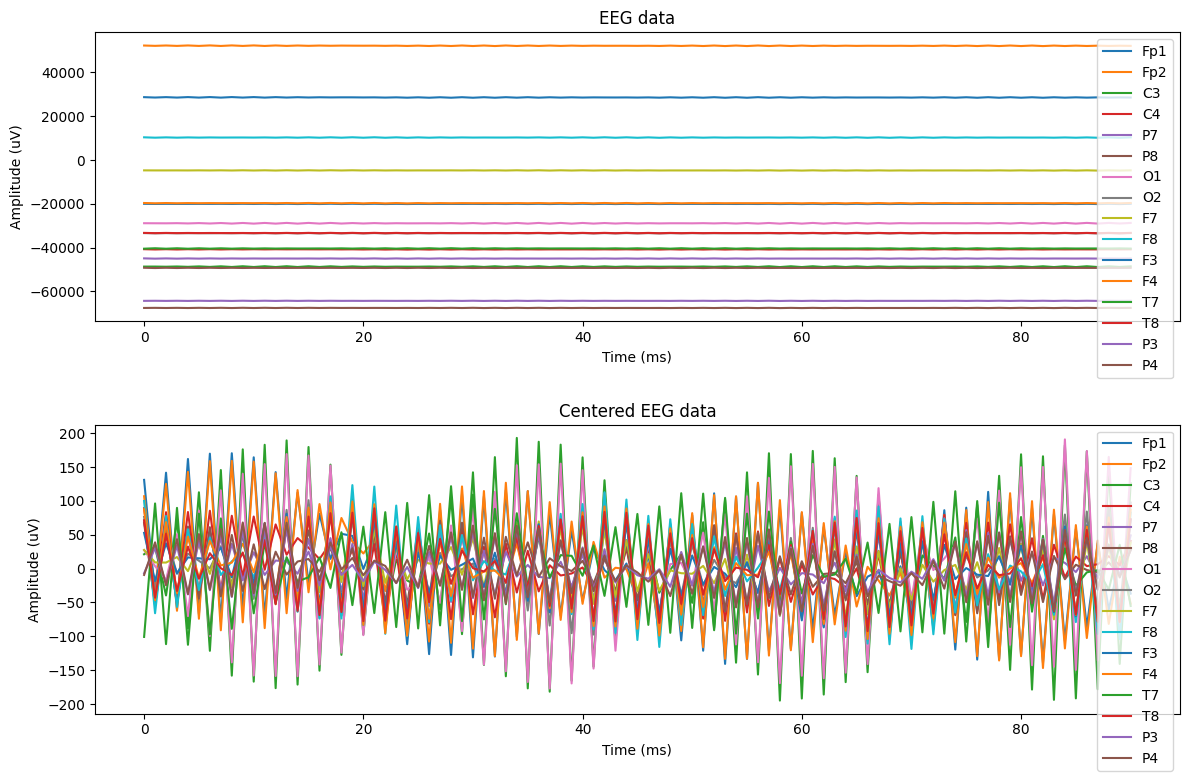

In [61]:
cat = pd.read_csv('processed_data/eeg_data_cat_2.csv')
plot_in_grid([plot_eeg_data_same_plot(cat),
            plot_eeg_data_same_plot(cat, centered=True)], 
            (2, 1))

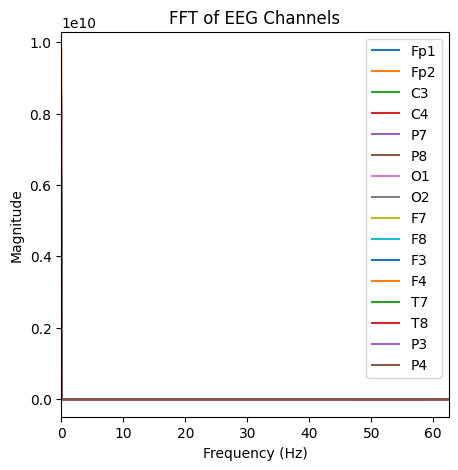

In [62]:
def plot_eeg_fft(eeg_data, plot=False):
    def plot_func(ax):
        sampling_rate = 125
        N = len(eeg_data)  # Number of data points

        for column in eeg_data.columns:
            # Compute FFT
            fft_values = np.fft.fft(eeg_data[column])
            frequencies = np.fft.fftfreq(N, 1/sampling_rate)

            # Plot the magnitude of the FFT
            ax.plot(frequencies, np.abs(fft_values), label=column)

        ax.set_title('FFT of EEG Channels')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Magnitude')
        ax.set_xlim(0, sampling_rate / 2)  # Limit x-axis to positive frequencies
        ax.legend()

    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        plot_func(ax)
        plt.show()
    else:
        return plot_func

plot_eeg_fft(eeg_df, plot=True)

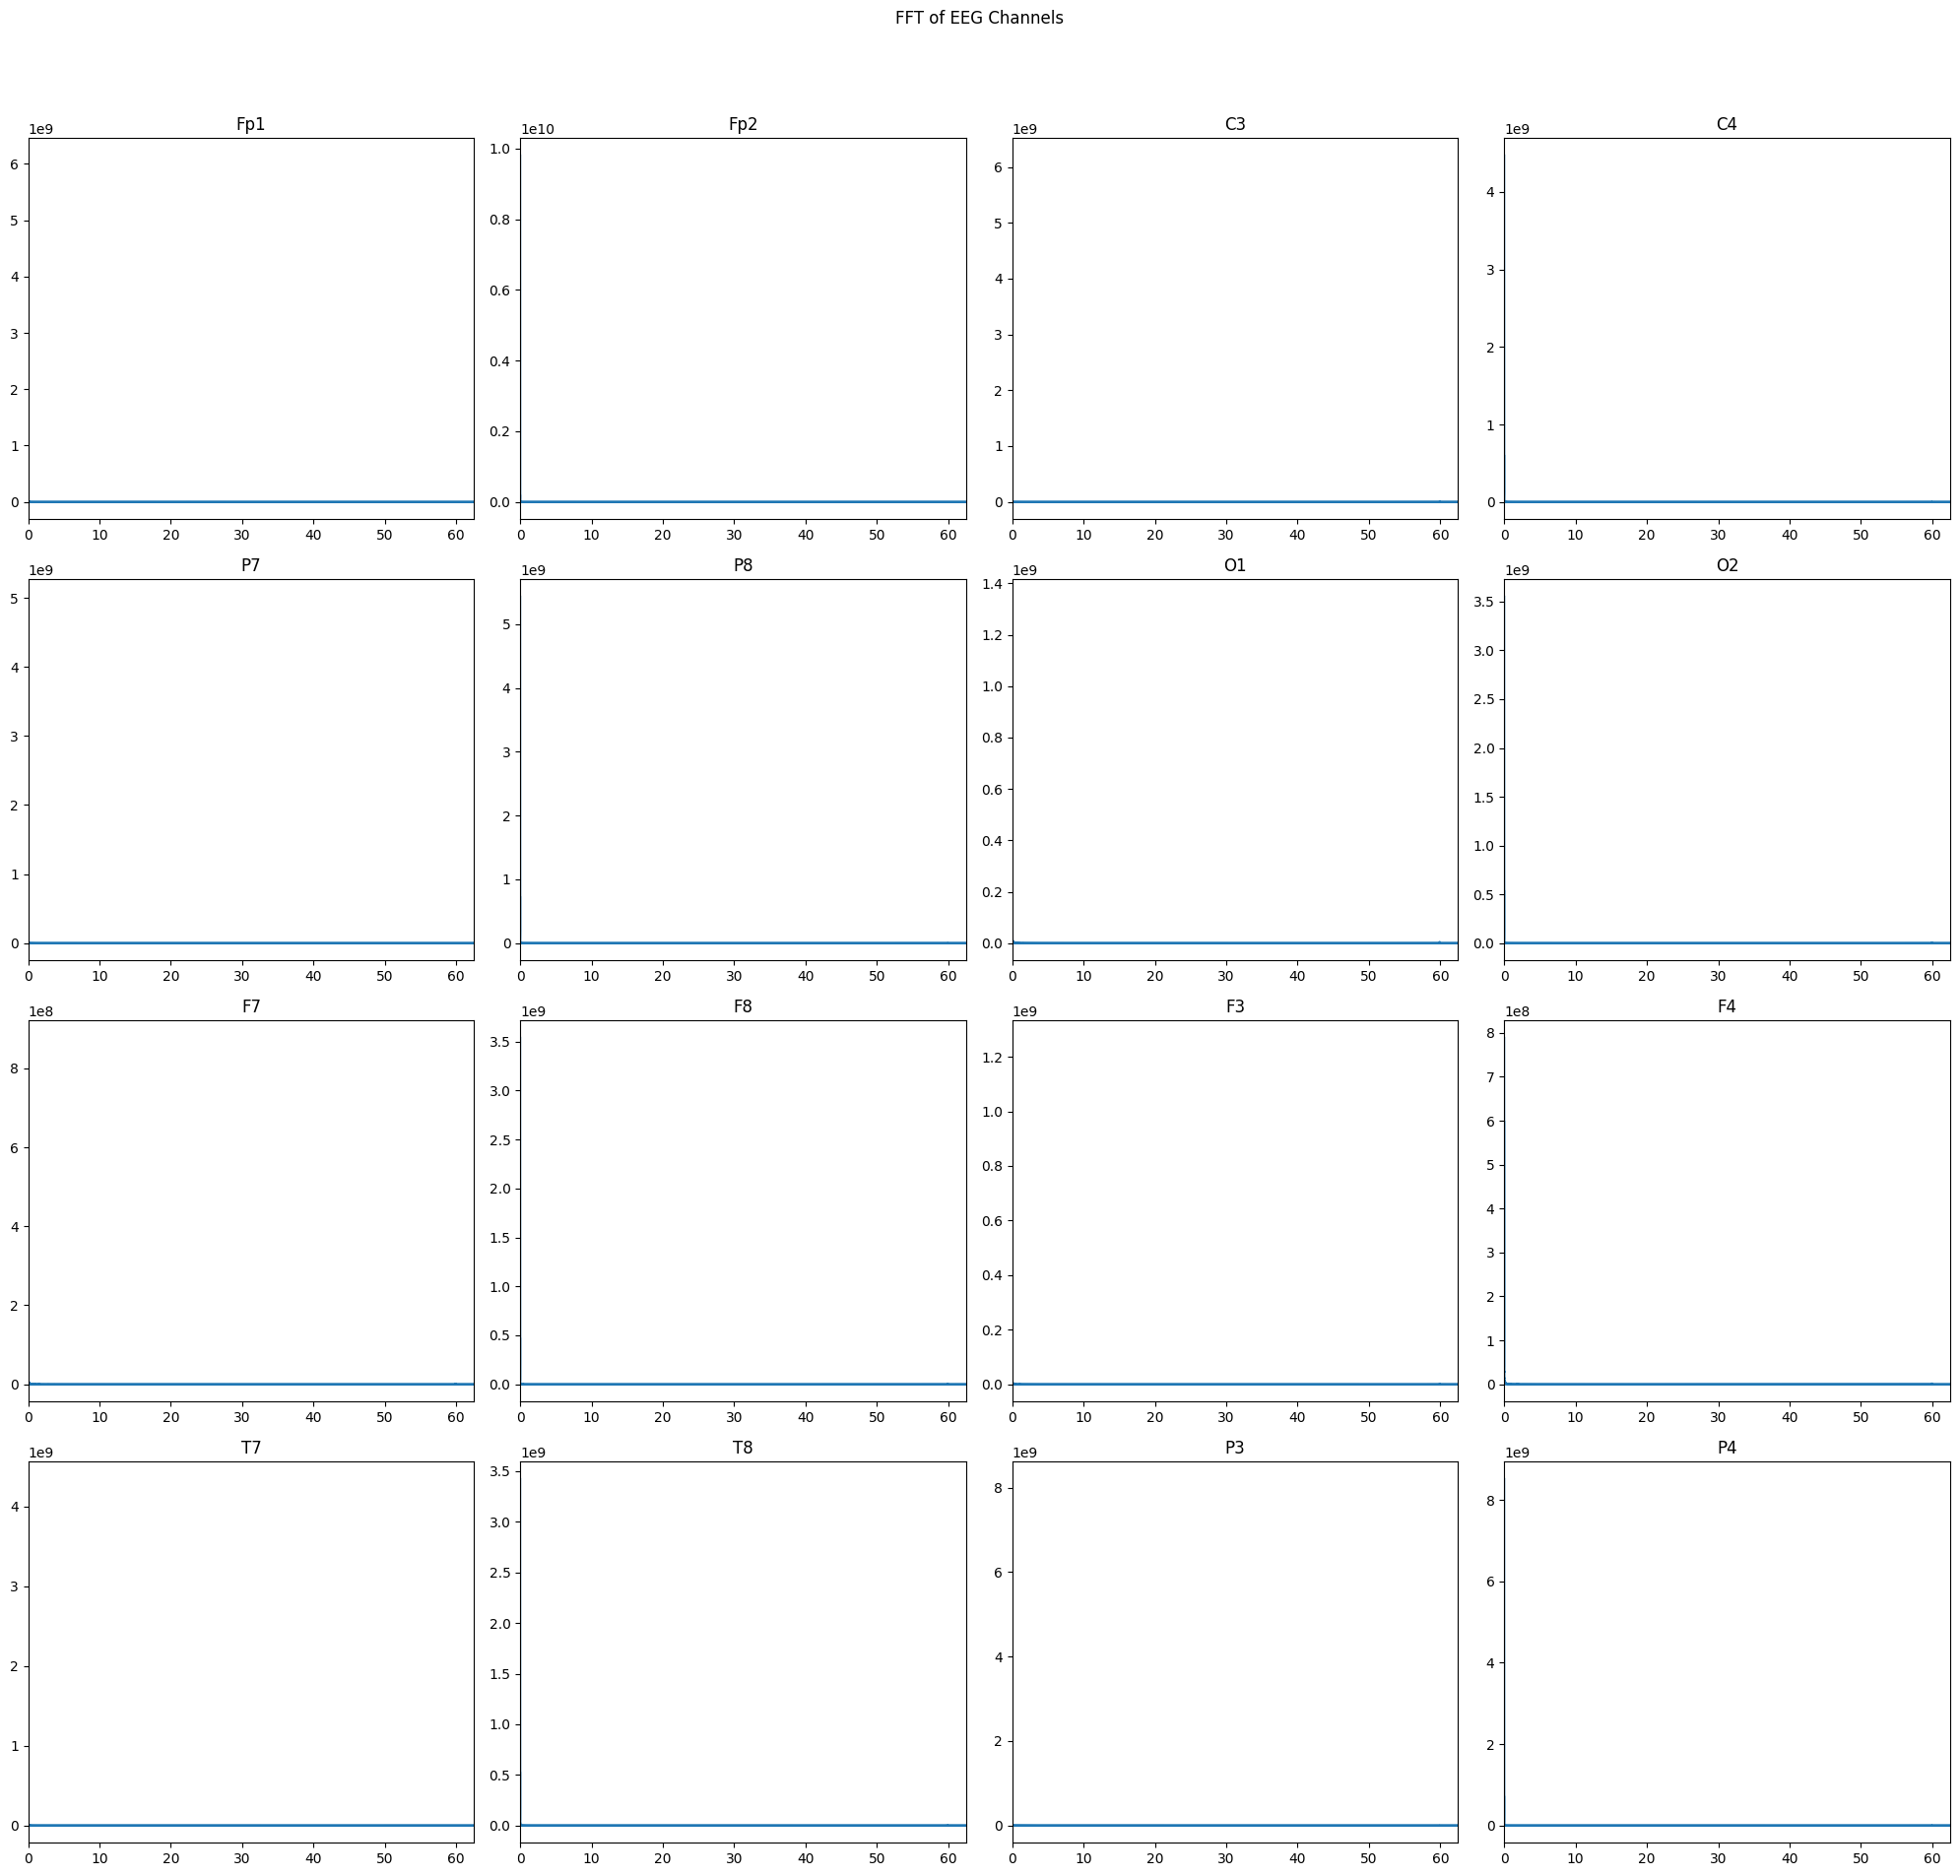

In [63]:
def plot_eeg_fft_grid(eeg_data):
    '''
    Plots the Fast Fourier Transform of each channel of the EEG data in a 3x4 grid.
    Params: 
        eeg_data: pandas DataFrame with the EEG data
    '''
    eeg_columns = eeg_data.columns
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # 4 rows, 4 columns grid of plots
    fig.suptitle('FFT of EEG Channels')

    sampling_rate = 125  
    N = len(eeg_data)  # Number of data points

    for i, column in enumerate(eeg_columns):
        # Compute FFT
        fft_values = np.fft.fft(eeg_data[column])
        frequencies = np.fft.fftfreq(N, 1/sampling_rate)

        # Determine the row and column to place the subplot
        row = i // 4
        col = i % 4

        # Plot the magnitude of the FFT in the appropriate subplot
        axs[row, col].plot(frequencies, np.abs(fft_values))
        axs[row, col].set_title(column)
        axs[row, col].set_xlim(0, sampling_rate / 2)  # Limit x-axis to positive frequencies

    # Adjust layout to prevent overlap of subplot titles and axes labels
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_eeg_fft_grid(eeg_df)


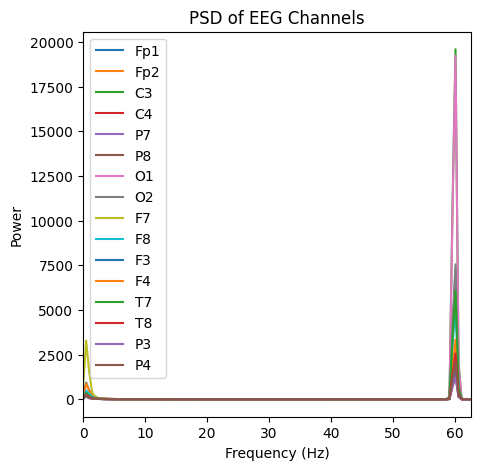

In [64]:
def plot_eeg_psd(eeg_data, plot=False):
    def plot_func(ax):
        sampling_rate = 125
        N = len(eeg_data)  # Number of data points

        for column in eeg_data.columns:
            # Compute PSD
            frequencies, psd_values = welch(eeg_data[column], fs=sampling_rate)

            # Plot the magnitude of the PSD
            ax.plot(frequencies, psd_values, label=column)

        ax.set_title('PSD of EEG Channels')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power')
        ax.set_xlim(0, sampling_rate / 2)  # Limit x-axis to positive frequencies
        ax.legend()

    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        plot_func(ax)
        plt.show()
    else:
        return plot_func

plot_eeg_psd(eeg_df, plot=True)

c:\Users\mateo\anaconda3\envs\neurolab\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 91, using nperseg = 91
  warnings.warn('nperseg = {0:d} is greater than input length '


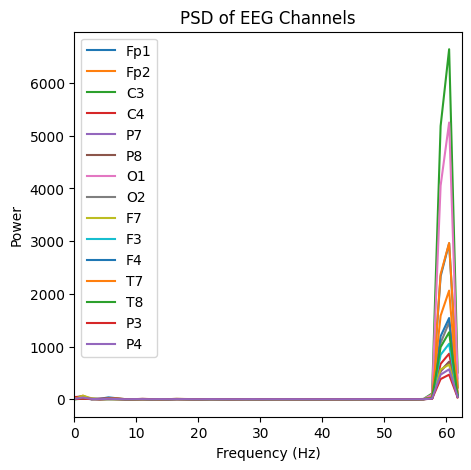

In [65]:
plot_eeg_psd(cat.drop(['F8'], axis=1), plot=True)

In [66]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 125  # Example sample rate
lowcut = 1.0
highcut = 60.0

# Function to design a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter_df(data, around_cero=False, lowcut=1.0, highcut=60.0, fs=125, order=5):
    '''
    Applies a bandpass filter to each column of the input DataFrame and adds the original unfiltered mean
    Params:
        data: pandas DataFrame with the data to filter
        around_cero: boolean indicating whether to add the original unfiltered mean (default: False)
        lowcut: low cutoff frequency of the bandpass filter
        highcut: high cutoff frequency of the bandpass filter
        fs: sampling rate of the data
        order: order of the Butterworth filter
    '''
    filtered_data = pd.DataFrame()
    if around_cero:
        for column in data.columns:
            filtered_data[column] = butter_bandpass_filter(data[column], lowcut, highcut, fs, order=order)
    else:
        for column in data.columns:
            filtered_data[column] = butter_bandpass_filter(data[column], lowcut, highcut, fs, order=order)\
                                    + np.mean(data[column])
    return filtered_data

# Apply the bandpass filter to the EEG data
filtered_eeg_df = butter_bandpass_filter_df(eeg_df)
filtered_eeg_df_centered = butter_bandpass_filter_df(eeg_df, around_cero=True)

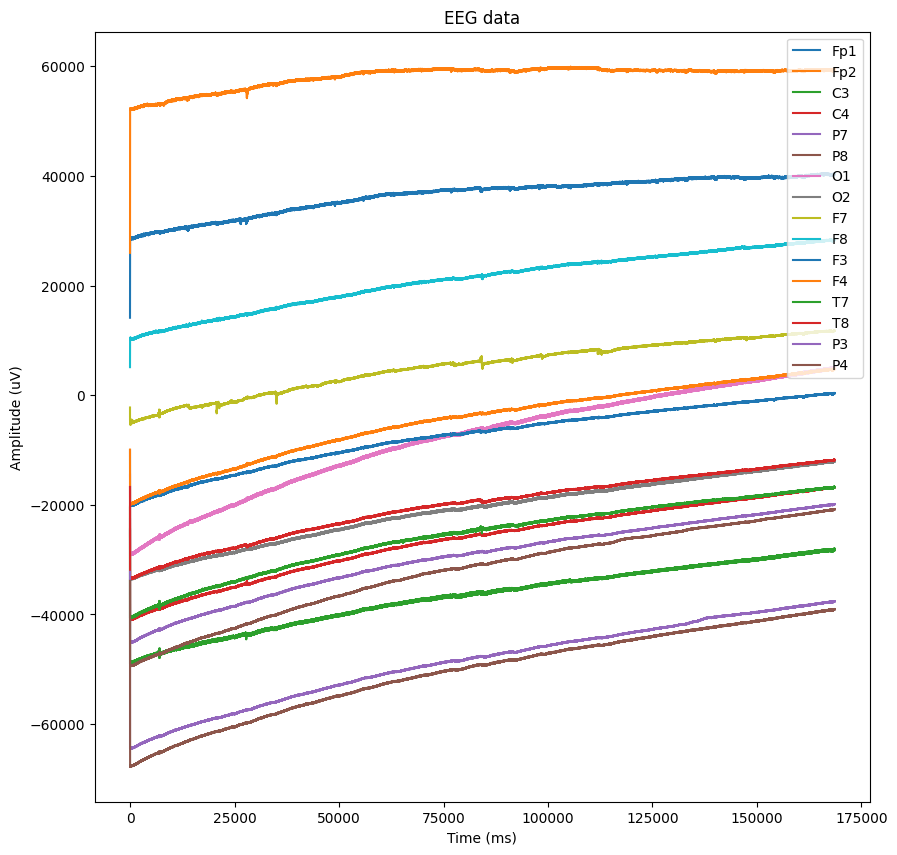

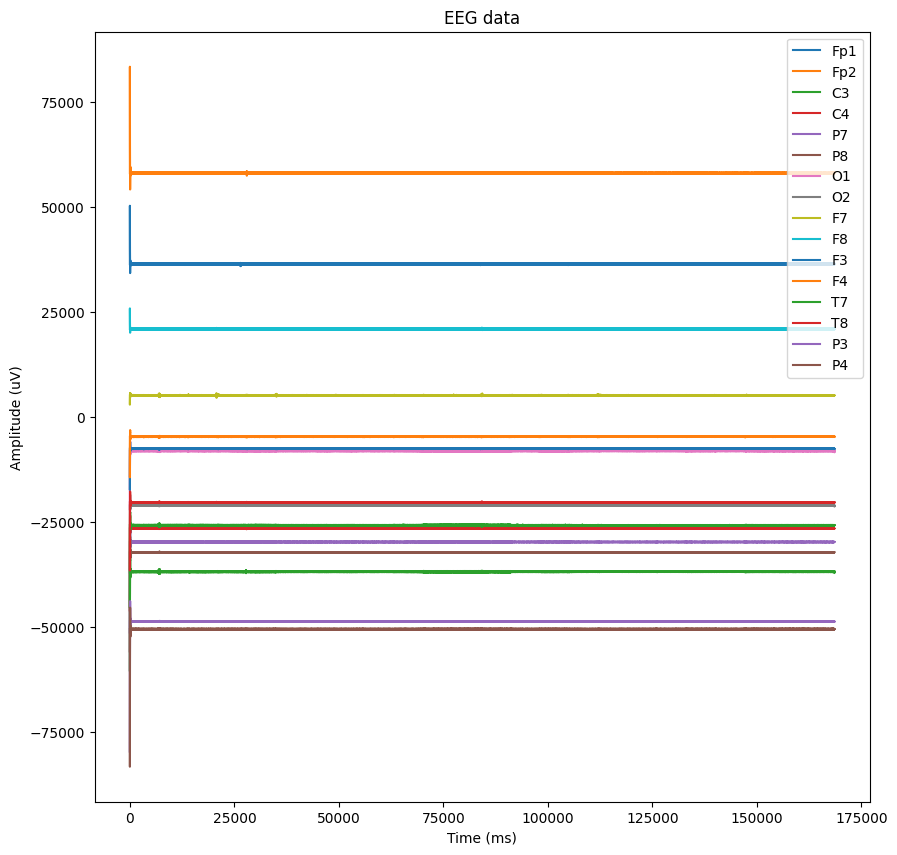

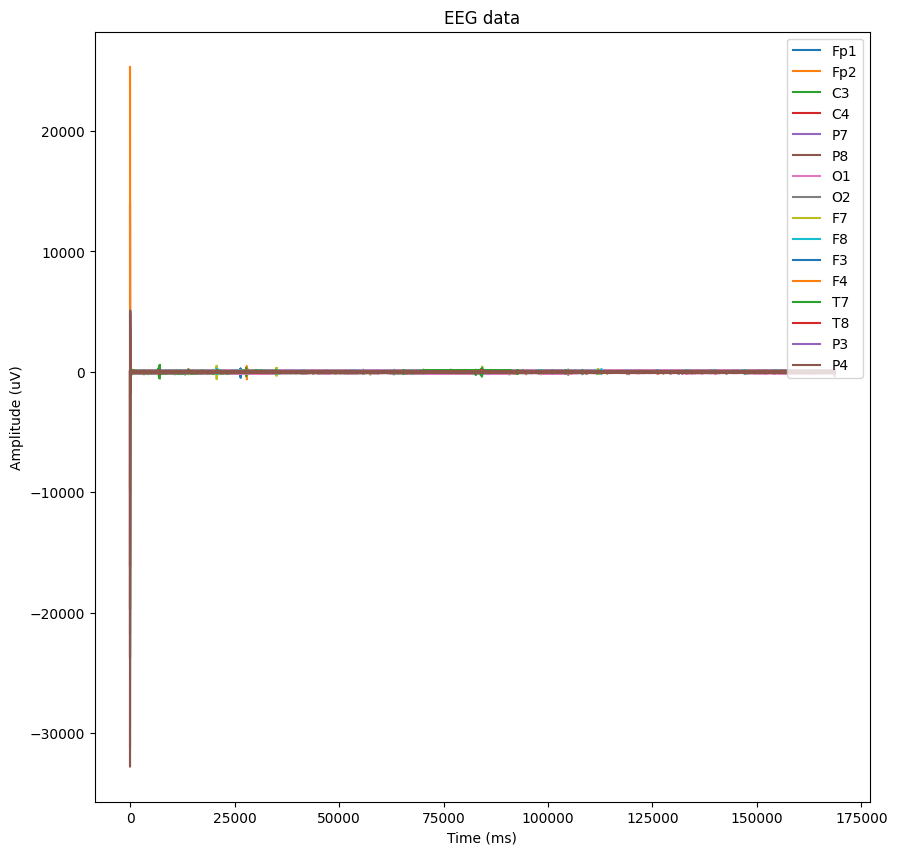

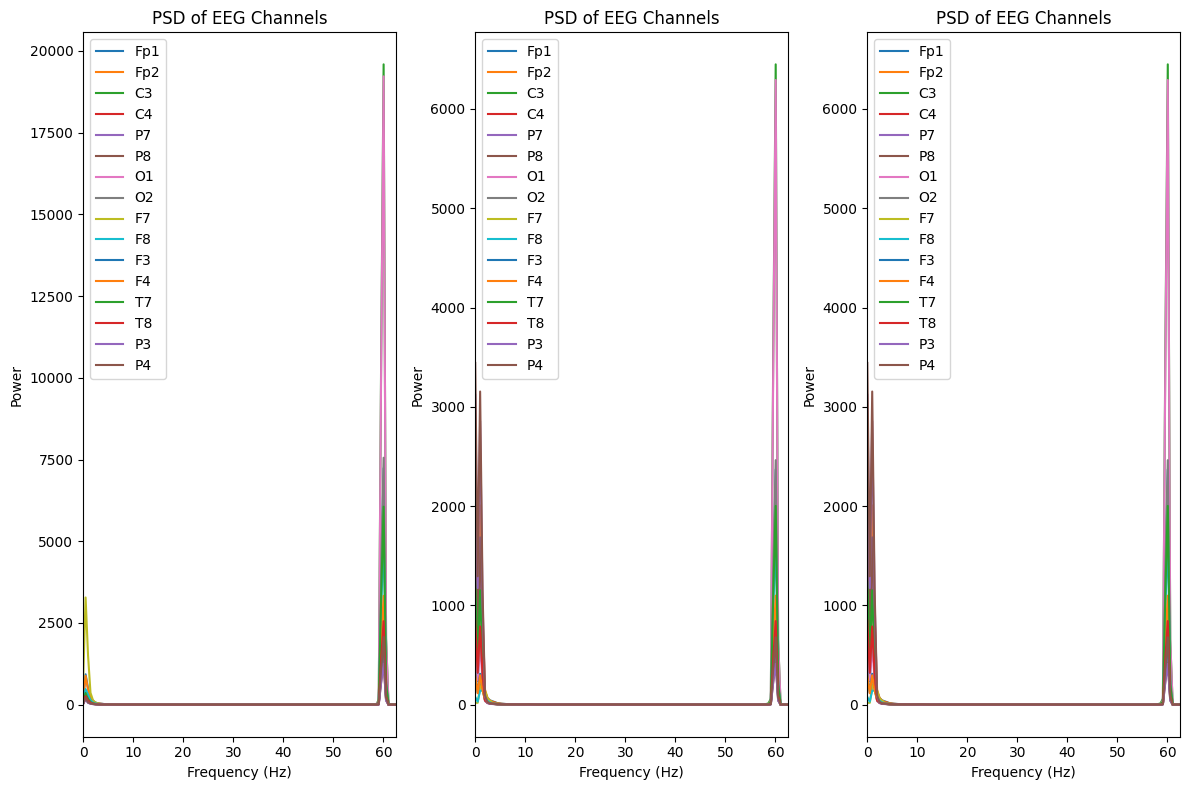

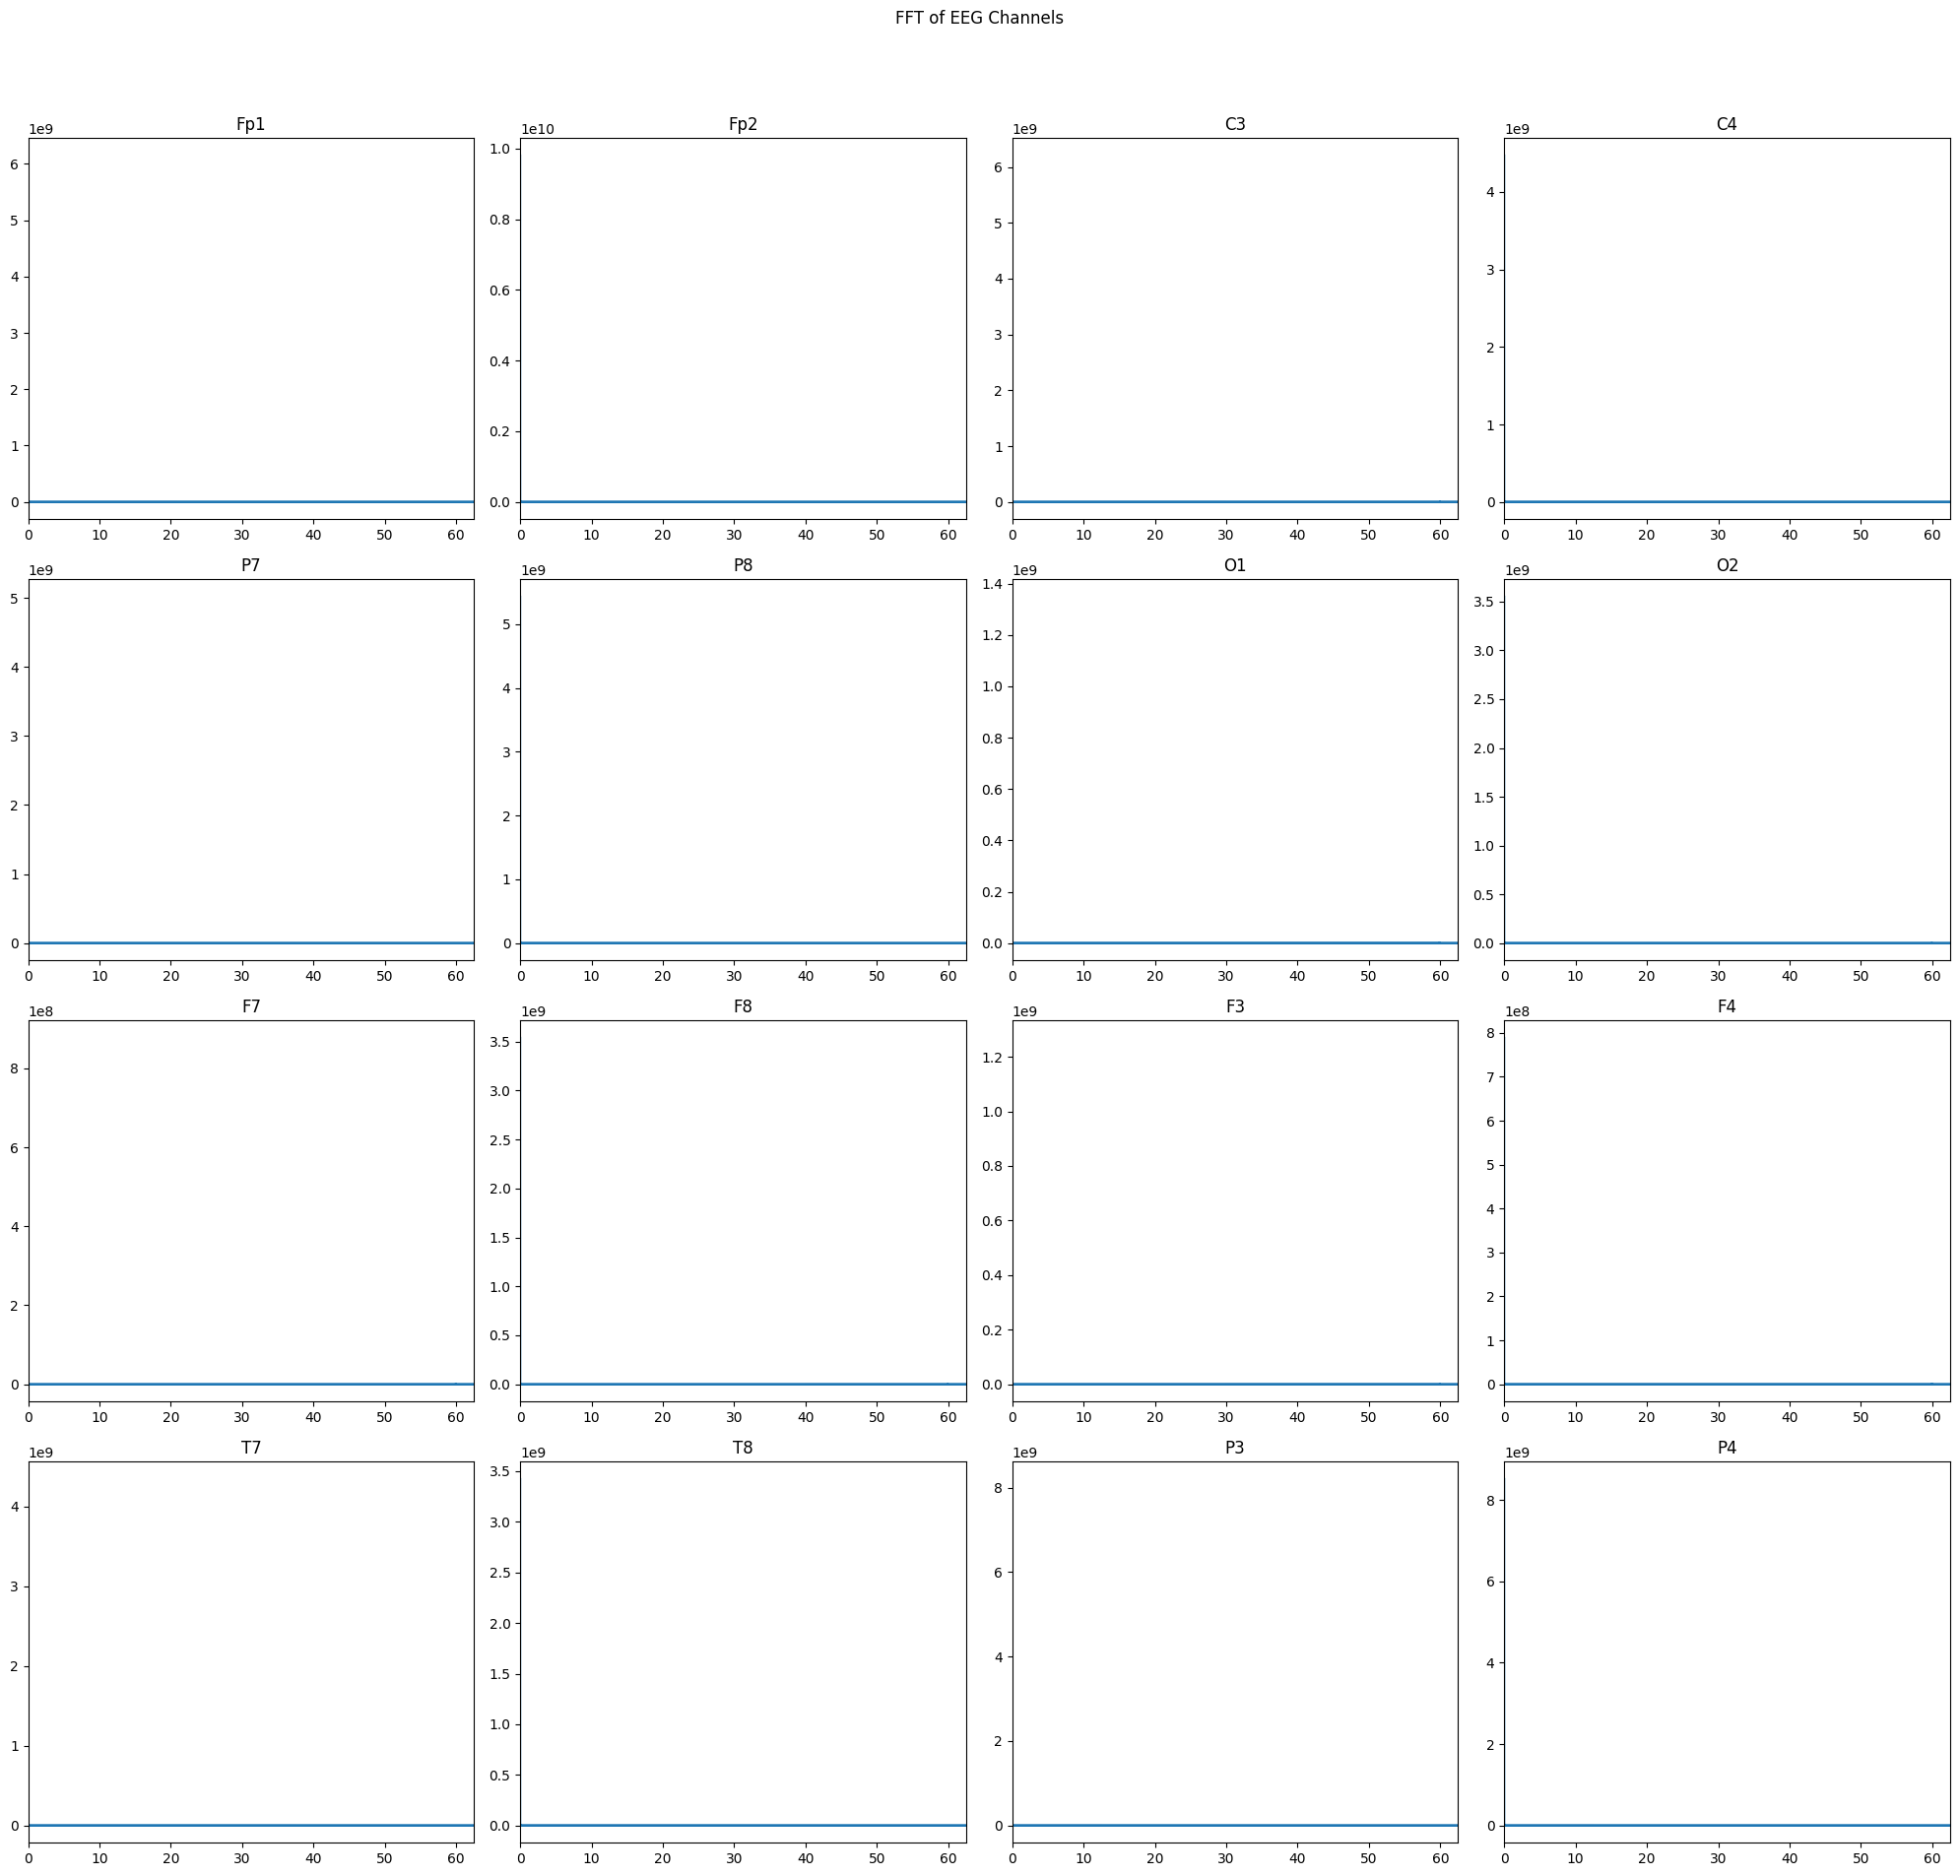

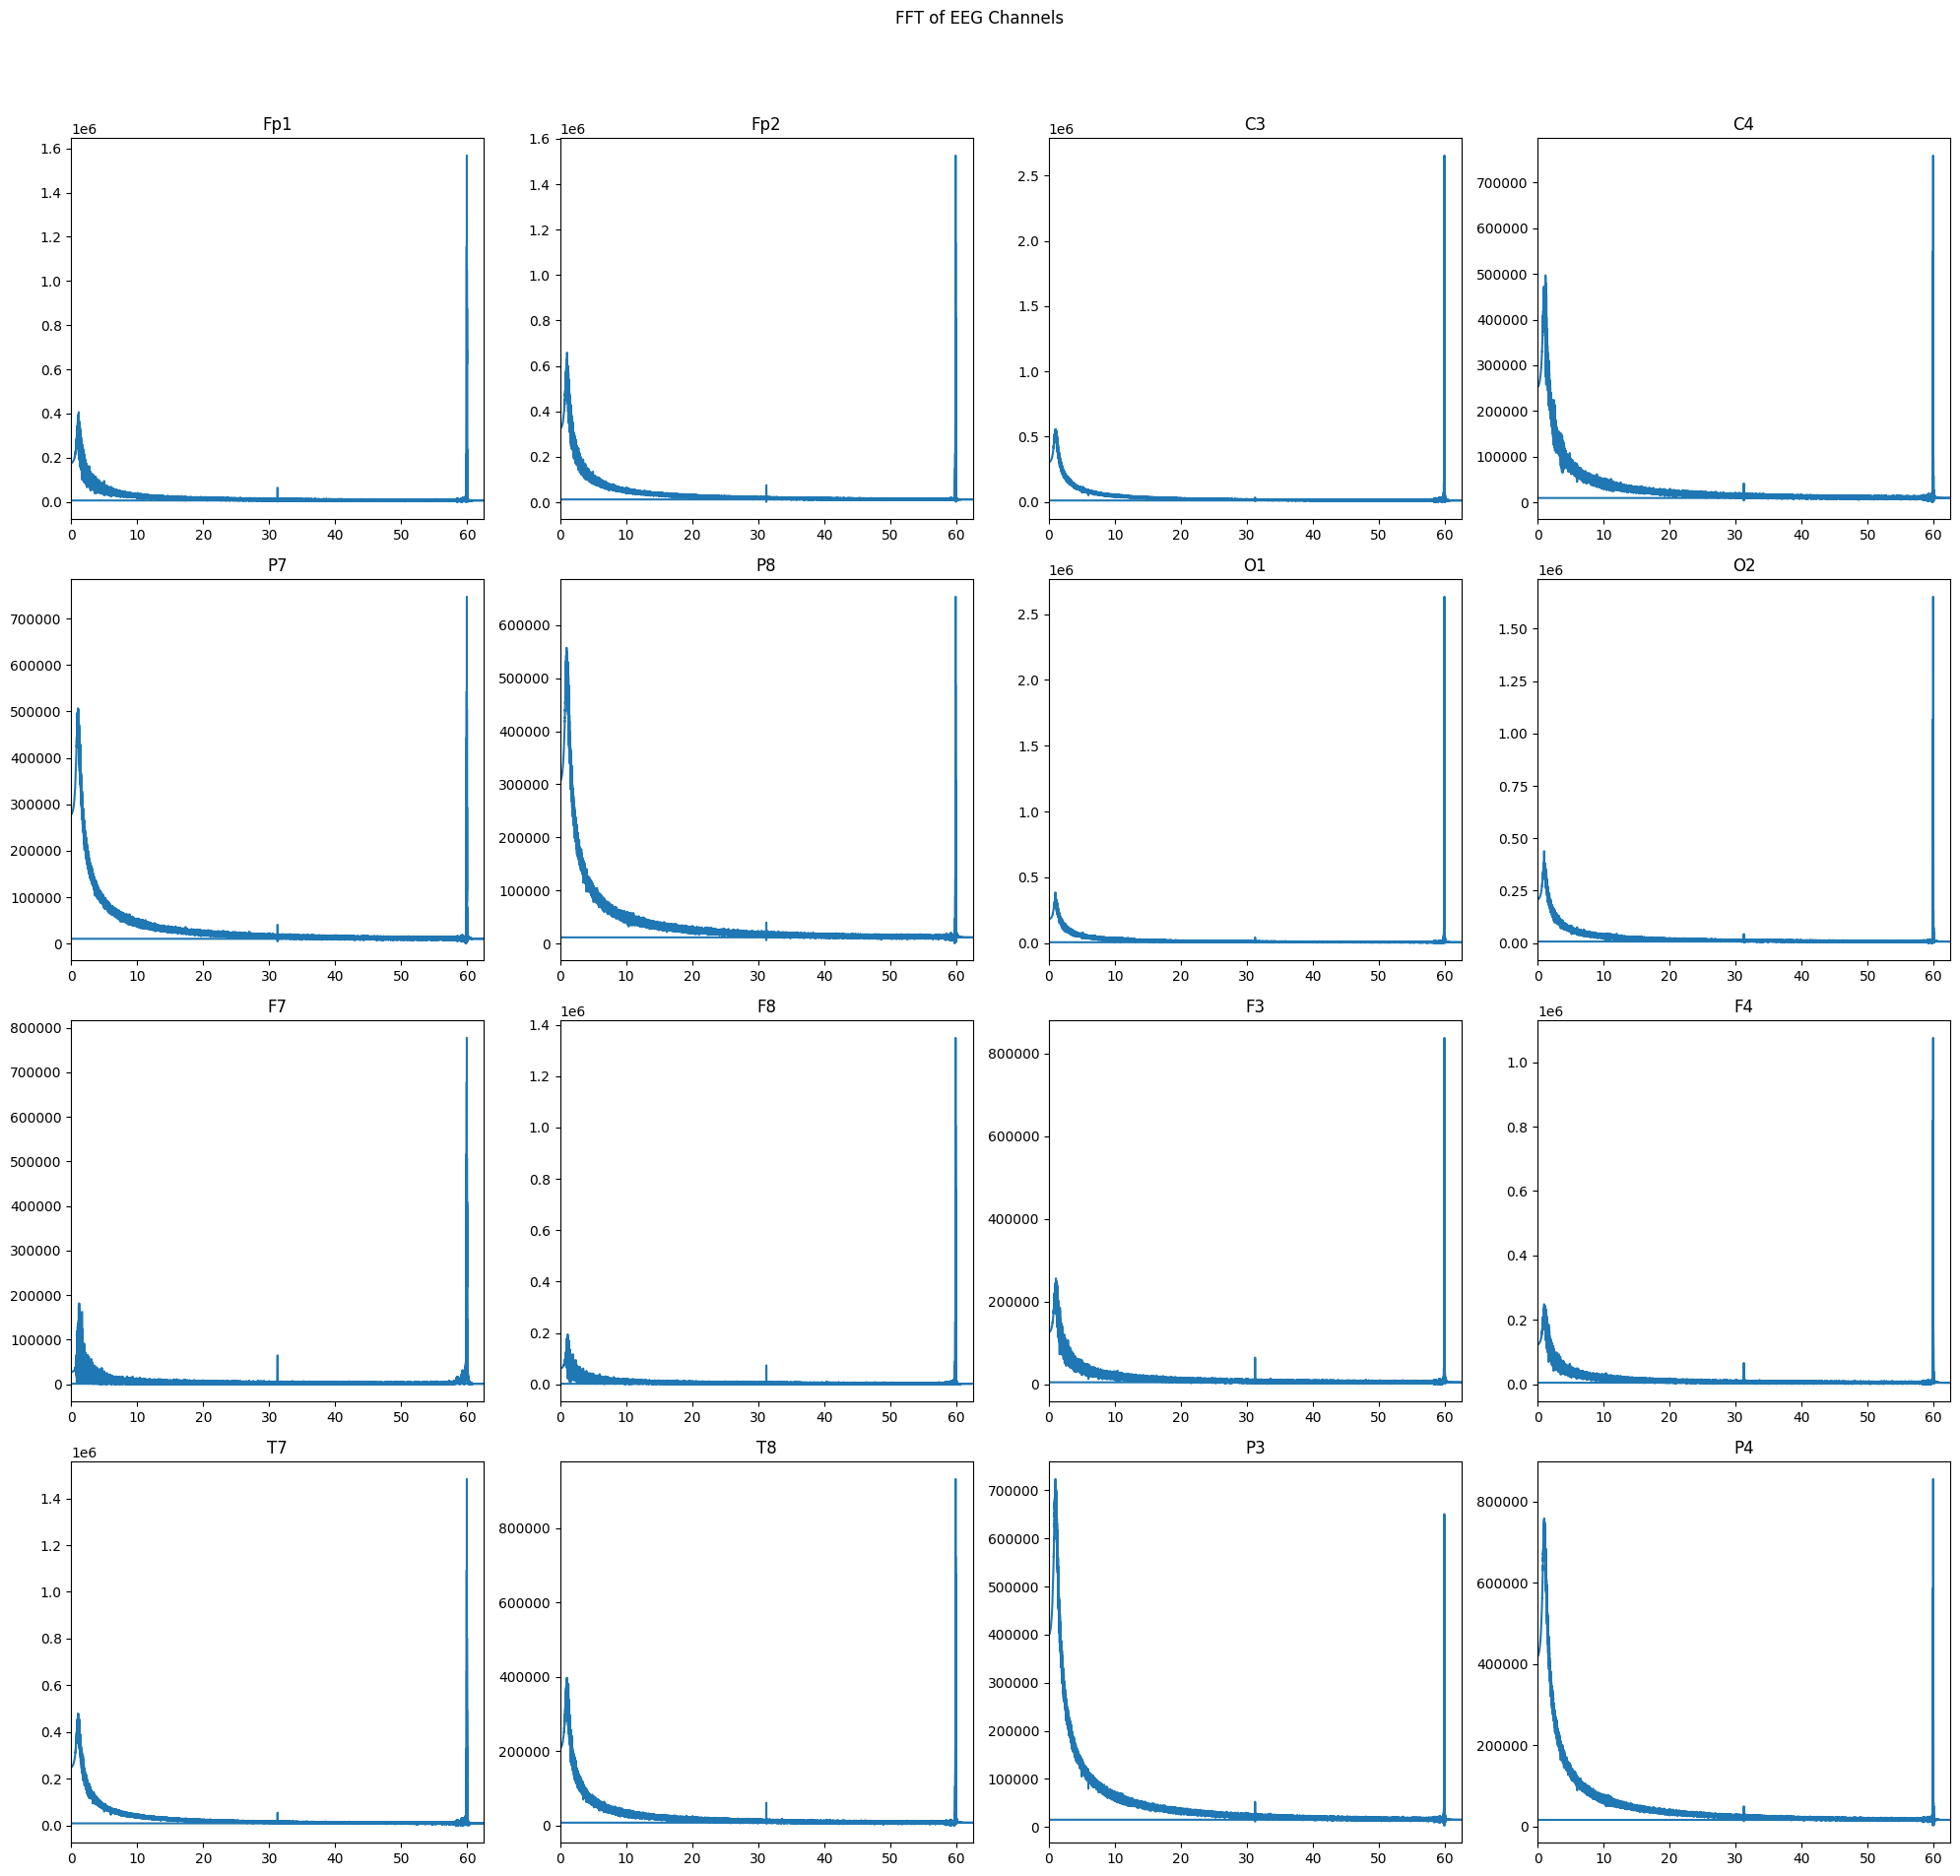

In [67]:
# Plot the filtered data
plot_eeg_data_same_plot(eeg_df, plot=True)
plot_eeg_data_same_plot(filtered_eeg_df, plot=True)
plot_eeg_data_same_plot(filtered_eeg_df_centered, plot=True)

# Plot the psd of the filtered data
plot_in_grid([plot_eeg_psd(eeg_df),
            plot_eeg_psd(filtered_eeg_df),
            plot_eeg_psd(filtered_eeg_df_centered)], 
            (1, 3))

plot_eeg_fft_grid(filtered_eeg_df)
plot_eeg_fft_grid(filtered_eeg_df_centered)


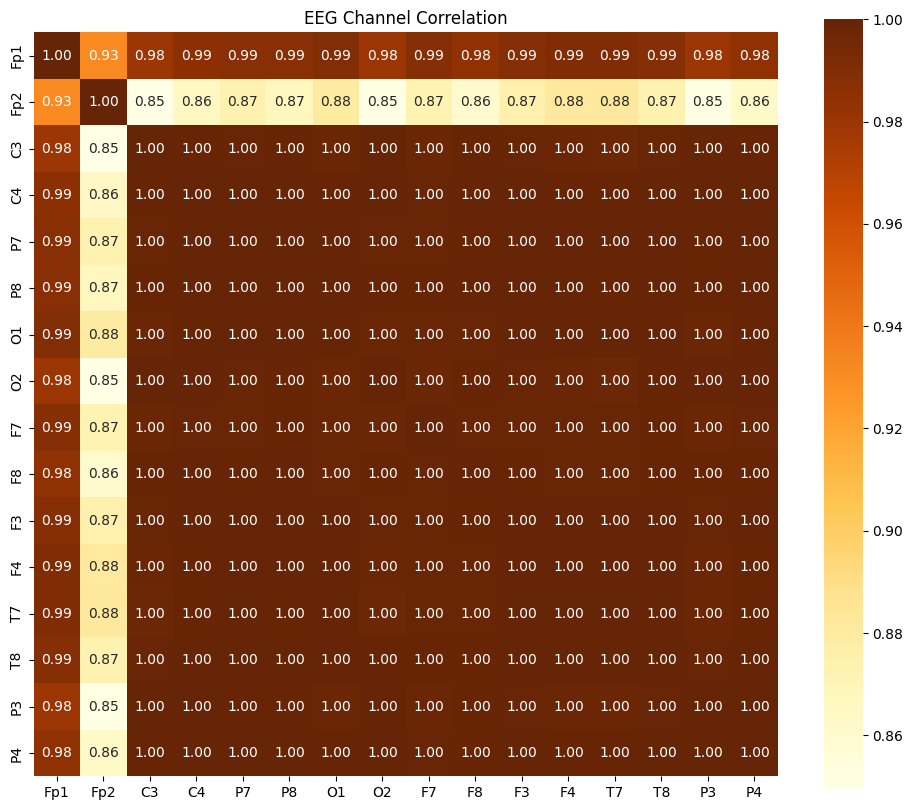

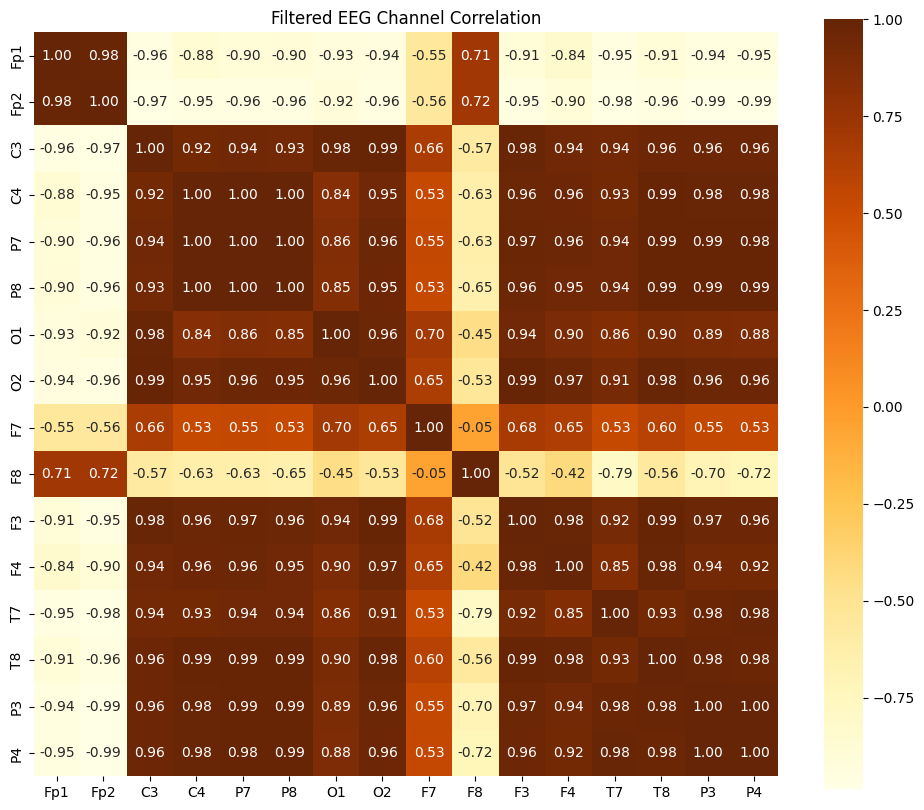

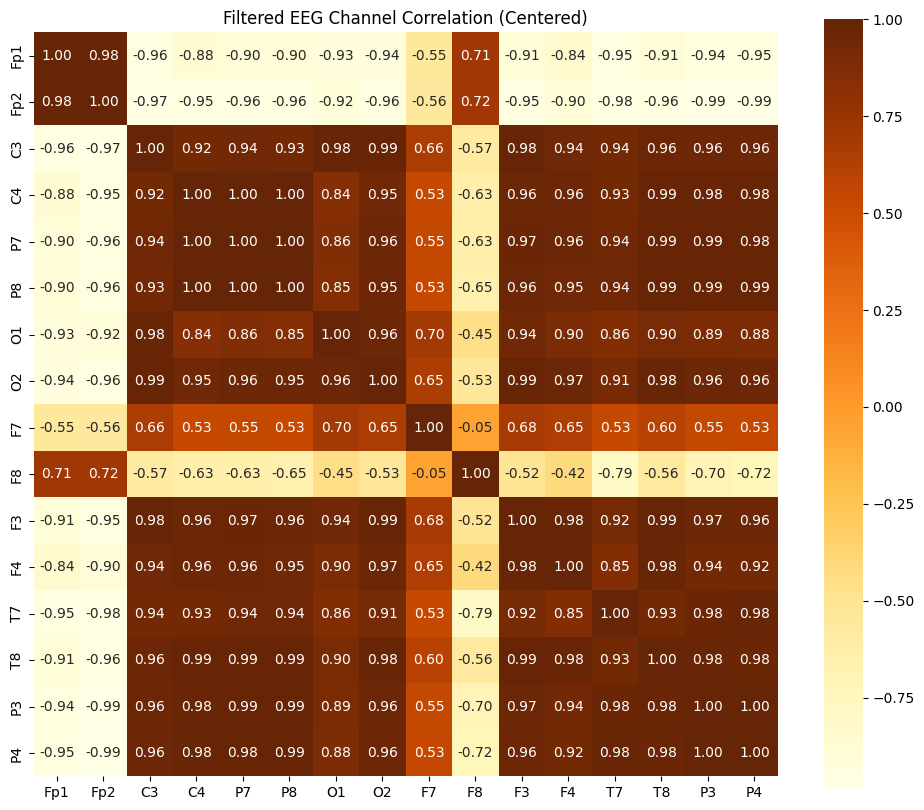

In [68]:
def plot_correlation_matrix(eeg_data, cmap='coolwarm', title='EEG Channel Correlation'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(eeg_data.corr(), annot=True, fmt=".2f", square=True, cmap=cmap)
    plt.title(title)
    plt.show()

plot_correlation_matrix(eeg_df, cmap='YlOrBr')
plot_correlation_matrix(filtered_eeg_df, cmap='YlOrBr', title='Filtered EEG Channel Correlation')
plot_correlation_matrix(filtered_eeg_df_centered, cmap='YlOrBr', title='Filtered EEG Channel Correlation (Centered)')

In [69]:
cat.dtypes

Fp1    float64
Fp2    float64
C3     float64
C4     float64
P7     float64
P8     float64
O1     float64
O2     float64
F7     float64
F8     float64
F3     float64
F4     float64
T7     float64
T8     float64
P3     float64
P4     float64
dtype: object

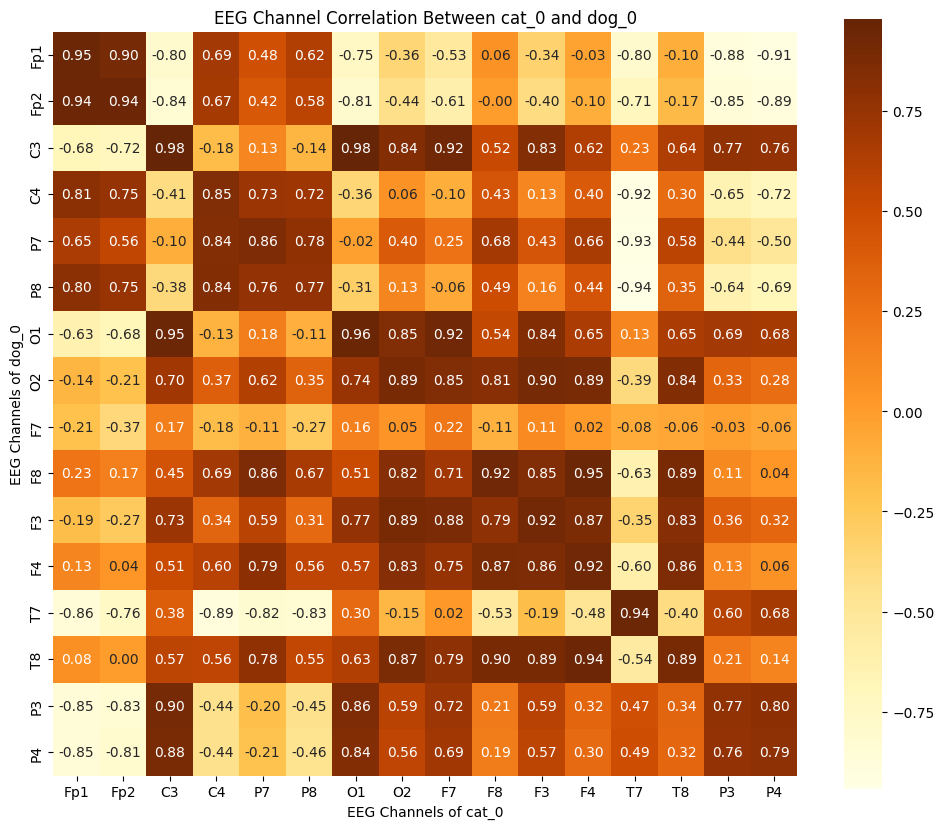

In [72]:
# correlation matrix between two different images
def plot_correlation_matrix_two_images(eeg_data1, eeg_data2, name1='Image 1', name2='Image 2', cmap='coolwarm', plot=False):
    '''
    Plots the correlation matrix between two sets of EEG data.
    Params:
        eeg_data1: pandas DataFrame with the first set of EEG data
        eeg_data2: pandas DataFrame with the second set of EEG data
        name1: string representing the name of the first DataFrame
        name2: string representing the name of the second DataFrame
        cmap: colormap for the heatmap (default: 'coolwarm')
    '''
    def plot_func(ax=None):
        # Ensure the columns are in the same order for both dataframes
        eeg_data1_aligned = eeg_data1[eeg_data2.columns]

        # Create a new DataFrame for correlations
        corr_matrix = pd.DataFrame()

        # Calculate correlation for each column
        for column in eeg_data1_aligned.columns:
            corr_matrix[column] = eeg_data1_aligned.corrwith(eeg_data2[column])

        if ax is None:
            ax = plt.gca()

        sns.heatmap(corr_matrix, annot=True, fmt=".2f", square=True, cmap=cmap, ax=ax)
        ax.set_title(f"EEG Channel Correlation Between {name1} and {name2}")
        ax.set_xlabel(f"EEG Channels of {name1}")  # X-axis label
        ax.set_ylabel(f"EEG Channels of {name2}")  # Y-axis label

    if plot:
        plt.figure(figsize=(12, 10))
        plot_func()
        plt.show()
    else:
        return plot_func


# Example usage
cat_image_str = 'cat_0'
dog_image_str = 'dog_0'

cat = pd.read_csv(f'processed_data/eeg_data_{cat_image_str}.csv')
dog = pd.read_csv(f'processed_data/eeg_data_{dog_image_str}.csv')
plot_correlation_matrix_two_images(cat, dog, name1=cat_image_str, name2=dog_image_str, cmap='YlOrBr', plot=True)
                                

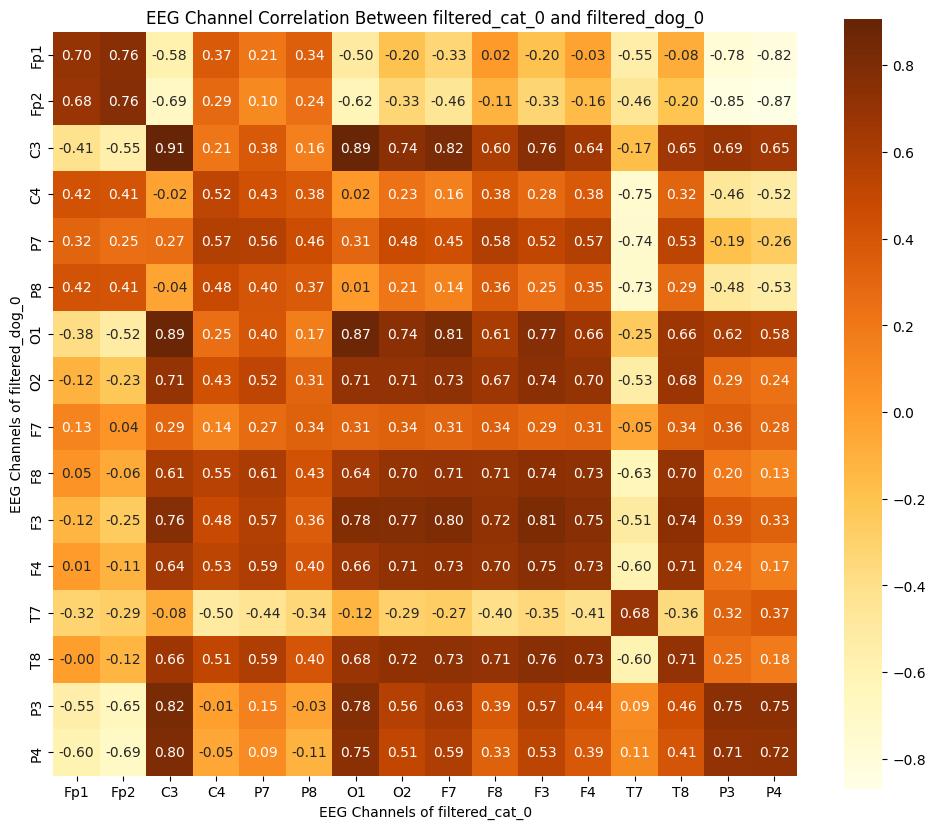

In [75]:
# correlation matrix between two different images filtered
filtered_cat = butter_bandpass_filter_df(cat)
filtered_dog = butter_bandpass_filter_df(dog)
plot_correlation_matrix_two_images(filtered_cat, filtered_dog, name1=f'filtered_{cat_image_str}', name2=f'filtered_{dog_image_str}', cmap='YlOrBr', plot=True)

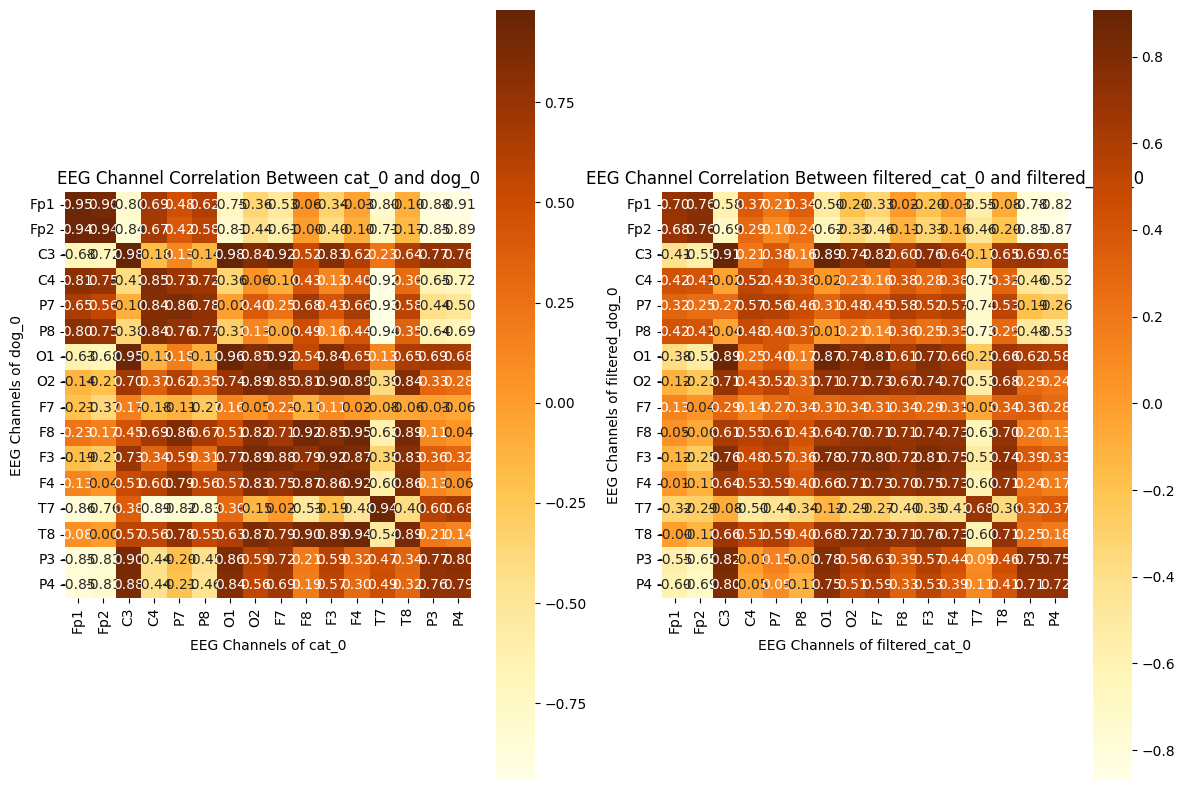

In [78]:
# grid of correlation matrices between all images
plot_in_grid([plot_correlation_matrix_two_images(cat, dog, name1=cat_image_str, name2=dog_image_str, cmap='YlOrBr'),
             plot_correlation_matrix_two_images(filtered_cat, filtered_dog, name1=f'filtered_{cat_image_str}', name2=f'filtered_{dog_image_str}', cmap='YlOrBr')
             ], (1, 2))

In [93]:
# check if the shape of all the images is the same
import os
from pprint import pprint

files = os.listdir('processed_data')
len_value_counts = {}
for file in files:
    if 'eeg_data' in file:
        df = pd.read_csv(f'processed_data/{file}')
        if df.shape[0] not in len_value_counts:
            len_value_counts[df.shape[0]] = [1, [file]]
        else:
            len_value_counts[df.shape[0]][0] += 1
            len_value_counts[df.shape[0]][1].append(file)
             
pprint(len_value_counts)
            #print(f'{file}: {df.shape}')

{0: [1, ['eeg_data_no_stimuli_23.csv']],
 35: [1, ['eeg_data_rabbit_251.csv']],
 47: [1, ['eeg_data_cat_202.csv']],
 72: [1, ['eeg_data_dog_250.csv']],
 82: [1, ['eeg_data_dog_191.csv']],
 91: [1, ['eeg_data_cat_2.csv']],
 100: [1, ['eeg_data_control_150.csv']],
 111: [2, ['eeg_data_control_248.csv', 'eeg_data_dog_18.csv']],
 112: [1, ['eeg_data_dog_103.csv']],
 113: [1, ['eeg_data_cat_52.csv']],
 114: [1, ['eeg_data_cat_3.csv']],
 115: [1, ['eeg_data_dog_50.csv']],
 119: [1, ['eeg_data_control_82.csv']],
 120: [3,
       ['eeg_data_control_0.csv',
        'eeg_data_control_250.csv',
        'eeg_data_dog_185.csv']],
 121: [4,
       ['eeg_data_control_209.csv',
        'eeg_data_control_299.csv',
        'eeg_data_rabbit_209.csv',
        'eeg_data_rabbit_299.csv']],
 122: [20,
       ['eeg_data_cat_148.csv',
        'eeg_data_cat_15.csv',
        'eeg_data_cat_18.csv',
        'eeg_data_control_120.csv',
        'eeg_data_control_199.csv',
        'eeg_data_control_201.csv',
        

In [94]:
# print len_value_counts ordered
pprint(sorted(len_value_counts.items(), key=lambda x: x[1], reverse=True))

[(125,
  [549,
   ['eeg_data_cat_101.csv',
    'eeg_data_cat_102.csv',
    'eeg_data_cat_103.csv',
    'eeg_data_cat_108.csv',
    'eeg_data_cat_110.csv',
    'eeg_data_cat_111.csv',
    'eeg_data_cat_113.csv',
    'eeg_data_cat_114.csv',
    'eeg_data_cat_116.csv',
    'eeg_data_cat_118.csv',
    'eeg_data_cat_121.csv',
    'eeg_data_cat_127.csv',
    'eeg_data_cat_13.csv',
    'eeg_data_cat_131.csv',
    'eeg_data_cat_134.csv',
    'eeg_data_cat_136.csv',
    'eeg_data_cat_137.csv',
    'eeg_data_cat_139.csv',
    'eeg_data_cat_14.csv',
    'eeg_data_cat_142.csv',
    'eeg_data_cat_143.csv',
    'eeg_data_cat_144.csv',
    'eeg_data_cat_145.csv',
    'eeg_data_cat_150.csv',
    'eeg_data_cat_151.csv',
    'eeg_data_cat_153.csv',
    'eeg_data_cat_154.csv',
    'eeg_data_cat_155.csv',
    'eeg_data_cat_156.csv',
    'eeg_data_cat_159.csv',
    'eeg_data_cat_163.csv',
    'eeg_data_cat_165.csv',
    'eeg_data_cat_166.csv',
    'eeg_data_cat_167.csv',
    'eeg_data_cat_168.csv',
    'ee

In [ ]:
# files with shape[0] == 751


In [88]:
# print the name of the csv that has a different shape than 124 125 126
for file in files:
    if 'eeg_data' in file:
        df = pd.read_csv(f'processed_data/{file}')
        if df.shape[0] != 124 and df.shape[0] != 125 and df.shape[0] != 126:
            print(f'{file}: {df.shape}')
            

eeg_data_cat_1.csv: (170, 16)
eeg_data_cat_11.csv: (123, 16)
eeg_data_cat_12.csv: (128, 16)
eeg_data_cat_147.csv: (129, 16)
eeg_data_cat_148.csv: (122, 16)
eeg_data_cat_149.csv: (123, 16)
eeg_data_cat_15.csv: (122, 16)
eeg_data_cat_17.csv: (128, 16)
eeg_data_cat_18.csv: (122, 16)
eeg_data_cat_199.csv: (123, 16)
eeg_data_cat_2.csv: (91, 16)
eeg_data_cat_201.csv: (203, 16)
eeg_data_cat_202.csv: (47, 16)
eeg_data_cat_24.csv: (127, 16)
eeg_data_cat_25.csv: (123, 16)
eeg_data_cat_3.csv: (114, 16)
eeg_data_cat_4.csv: (127, 16)
eeg_data_cat_49.csv: (123, 16)
eeg_data_cat_51.csv: (137, 16)
eeg_data_cat_52.csv: (113, 16)
eeg_data_cat_99.csv: (123, 16)
eeg_data_control_0.csv: (120, 16)
eeg_data_control_106.csv: (123, 16)
eeg_data_control_120.csv: (122, 16)
eeg_data_control_121.csv: (127, 16)
eeg_data_control_122.csv: (127, 16)
eeg_data_control_126.csv: (123, 16)
eeg_data_control_128.csv: (128, 16)
eeg_data_control_129.csv: (123, 16)
eeg_data_control_134.csv: (127, 16)
eeg_data_control_135.csv: (

In [ ]:
# df = pd.read_csv(f'processed_data/eeg_data_control_')